In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.transforms import v2
import numpy as np
# import PIL

In [2]:
# import data
folder="./dataset"
# transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize((224, 224))])
data_train_val=torchvision.datasets.FashionMNIST(root=folder,train=True,download=True,transform=None)
data_test=torchvision.datasets.FashionMNIST(root=folder,train=False,download=True,transform=None)

In [3]:
classes=data_test.classes

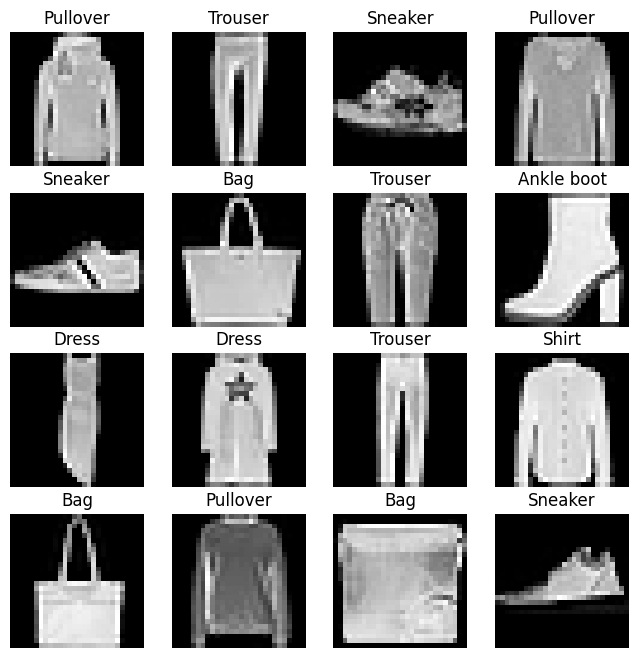

In [70]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize = (8,8))
cols, rows = 4, 4
ids=torch.randint(len(data_test), size = (cols*rows,))
for i in range (1, cols*rows + 1):
    image, label = data_test[ids[i-1].item()]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(image, cmap='gray')
    # plt.imshow(image.squeeze())
plt.show()

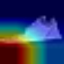

In [85]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

import requests
import torchvision
from PIL import Image
import numpy as np

# image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
# image = np.array(Image.open(requests.get(image_url, stream=True).raw))
# image=image[:,:,[0,0,0]]

transforms.ToTensor()(image).shape
transform_1 = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((64, 64)), 
    # transforms.ToTensor(),
    # transforms.Normalize(0.5, 0.5)
])
image_resize=transform_1(image)
# torch.max(tensor_input)
image_ts=np.array(image_resize)
image_ts2=image_ts[:,:,None]
image_ts2=image_ts2[:,:,[0,0,0]]

image_float_np = np.float32(image_ts2) / 255
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image_ts2)
input_tensor=input_tensor[None,:,:,:]

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
# input_tensor = # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)


# targets = [ClassifierOutputTarget(281)]
targets=[ClassifierOutputTarget(226)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)

In [67]:
image_float_np.shape

(28, 28)

In [5]:
# data_train_val.data[:2000].shape
data_test.data.shape
# type(data_train_val.data)
# data_test.targets.shape

torch.Size([10000, 28, 28])

### Data Preparation (10 points)
- (a) Data cleansing and transformation (5 points)

In [6]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, trans=None):
        self.x = inputs
        self.y = targets
        self.trans=trans
        
        # # for loss function
        # self.pos_indices = np.flatnonzero(targets==1)
        # self.pos_index_map = {}
        # for i, idx in enumerate(self.pos_indices):
        #     self.pos_index_map[idx] = i

    def __len__(self):
        return self.x.size()[0]

    def __getitem__(self, idx):
        # self.mode = 'train' #TODO
        # if self.mode == 'train':
        #    idx2 = self.pos_index_map[idx] if idx in self.pos_indices else -1

        if self.trans == None:
            # return (idx2, self.x[idx], self.y[idx])
            # print("no trans")
            return ( self.x[idx], self.y[idx])
        else:
            # return (idx2, self.trans(self.x[idx]), self.y[idx]) 
            # print("trans")
            return ( self.trans(self.x[idx]), self.y[idx]) 

def ds_trans(ds_input,trans_flag):
    data_input=ds_input.data.clone().detach()
    labels_input=ds_input.targets
    if data_input.ndim <= 3:
        transform_train_val = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomAffine(degrees=(0,3), translate=(0,0.05), scale=None, shear=(0,0.05)),
            transforms.RandomResizedCrop(size=(64,64),scale=(0.9,1.0),ratio=(0.9,1.1)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)
        ])
        transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((64, 64)), 
            transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)
        ])
        # transform_train_val = v2.Compose([
        #     v2.ToPILImage(),
        #     v2.Resize((64, 64)), 
        #     v2.RandomHorizontalFlip(0.5),
        #     v2.RandomResizedCrop(size=(64,64),scale=(0.9,1.0),ratio=(0.9,1.1)),
        #     v2.ToTensor(),
        #     v2.Normalize(0.5, 0.5)
        # ])
        # transform_test = v2.Compose([
        #     v2.ToPILImage(),
        #     v2.Resize((64, 64)), 
        #     v2.ToTensor(),
        #     v2.Normalize(0.5, 0.5)
        # ])
    elif data_input.ndim == 4:
        # Should not come here
        print("WRONG!")

    # data_input = data_input/255.0
    if torch.isnan(data_input).any():
        print("have NaN or Inf")
    # data_input = data_input.clone().detach()
    # data_input = torch.tensor(data_input, dtype=torch.float32)
    data_input = data_input[:,None,:,:]
    print(data_input.shape)
    # flag_labels = torch.tensor(flag_labels) 
    # flag_labels = flag_labels[:,None]
    # print(flag_labels.shape)
    
    if trans_flag==1:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_train_val)
    elif trans_flag==2:
        flag_ds_new = dataset(data_input, labels_input, trans=transform_test)
    else:
        flag_ds_new = dataset(data_input, labels_input, trans=None)
    return (flag_ds_new)
    

In [7]:
torchvision.__version__

'0.16.0'

In [8]:
ds_processed_train_val=ds_trans(ds_input=data_train_val,trans_flag=1)
ds_processed_test=ds_trans(ds_input=data_test,trans_flag=2)
# ds_processed.x.shape

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


- (b) Data splitting (i.e., training, validation, and test splits) (5 points)

In [9]:
from torch.utils.data.sampler import SubsetRandomSampler
# ds_processed_train_split, ds_processed_val_split = torch.utils.data.random_split(data_train_val, [50000, 10000]) 
# indices_train=ds_processed_train_split.indices
# indices_val=ds_processed_val_split.indices

random_seed=22
indices = list(range(data_train_val.targets.shape[0]))
np.random.seed(random_seed)
np.random.shuffle(indices)

indices_train=indices[:50000]
indices_val=indices[50000:]

ds_processed_train_sampler=SubsetRandomSampler(indices_train)
ds_processed_val_sampler=SubsetRandomSampler(indices_val)

# batch_size=64
batch_size=256
num_workers=10
loader_train = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_train_sampler,
                                            num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(ds_processed_train_val, batch_size=batch_size,sampler=ds_processed_val_sampler,
                                            num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(ds_processed_test, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)

In [10]:
for batch_idx, (inputs, targets) in enumerate(loader_train):
    break
print(inputs.shape)
print(targets.shape)

torch.Size([256, 1, 64, 64])
torch.Size([256])


In [11]:
len(loader_train)
len(loader_train.sampler)
# len(loader_train.dataset)

50000

## Model

In [12]:
device ='cuda' if torch.cuda.is_available else 'cpu'
print(f'Using {device} device')
# model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
model=torchvision.models.vgg11()
# model
# model.conv1=torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.features[0]=torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model=model.to(device)
# model

Using cuda device


In [13]:
# Define hyperparameters
learning_rate = 1e-4
epochs = 10

# Loss Function
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss(reduction='sum')

# Optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
def trainloop (dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        
        # Compute the error rate
        prediction = model(X)
        loss = loss_fn(prediction, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch*len(X)
            print(f'loss:{loss:>7f} [{current:>5d}/{size:>5d}]')
            
def evaluate (dataloader, model, loss_fn):
    # size = len(dataloader.dataset)
    size = len(dataloader.sampler)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f'Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [15]:
for i in range(epochs):
    print(f"Epoch {i+1}\n-------------------------------")
    trainloop(loader_train, model, loss_fn, optimizer)
    print("Training Dataset Error:")
    evaluate(loader_train, model, loss_fn)
    print("Validation Dataset Error:");
    evaluate(loader_val, model, loss_fn)
    print("Test Dataset Error:");
    evaluate(loader_test, model, loss_fn)

Epoch 1
-------------------------------
loss:6.892178 [    0/60000]
loss:0.762069 [25600/60000]
Training Dataset Error:
Accuracy: 80.1%, Avg loss: 0.502812 

Validation Dataset Error:
Accuracy: 80.2%, Avg loss: 0.507319 

Test Dataset Error:
Accuracy: 81.3%, Avg loss: 0.490604 

Epoch 2
-------------------------------
loss:0.485747 [    0/60000]
loss:0.411733 [25600/60000]
Training Dataset Error:
Accuracy: 85.4%, Avg loss: 0.381774 

Validation Dataset Error:
Accuracy: 84.7%, Avg loss: 0.388760 

Test Dataset Error:
Accuracy: 85.4%, Avg loss: 0.385210 

Epoch 3
-------------------------------
loss:0.355748 [    0/60000]
loss:0.329160 [25600/60000]
Training Dataset Error:
Accuracy: 87.3%, Avg loss: 0.344790 

Validation Dataset Error:
Accuracy: 87.0%, Avg loss: 0.365970 

Test Dataset Error:
Accuracy: 87.2%, Avg loss: 0.364851 

Epoch 4
-------------------------------
loss:0.252668 [    0/60000]
loss:0.299869 [25600/60000]
Training Dataset Error:
Accuracy: 89.3%, Avg loss: 0.289533 

Va